In [1]:
import dypac as dp
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import time
from nilearn import datasets
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
from dypac import Embedding

In [2]:
n_subjects = 10
adhd_dataset = datasets.fetch_adhd(n_subjects)
epi_filename = adhd_dataset.func[0]

/home/pbellec/env/dypac/lib/python3.7/site-packages/nilearn/datasets/func.py:439: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [3]:
import pickle
hf =  open('model.pickle','rb')
model = pickle.load(hf)
tseries = model.masker_.transform(epi_filename)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


In [4]:
emb = Embedding(X=model.components_.todense())

In [5]:
tseries_r = emb.compression(tseries)


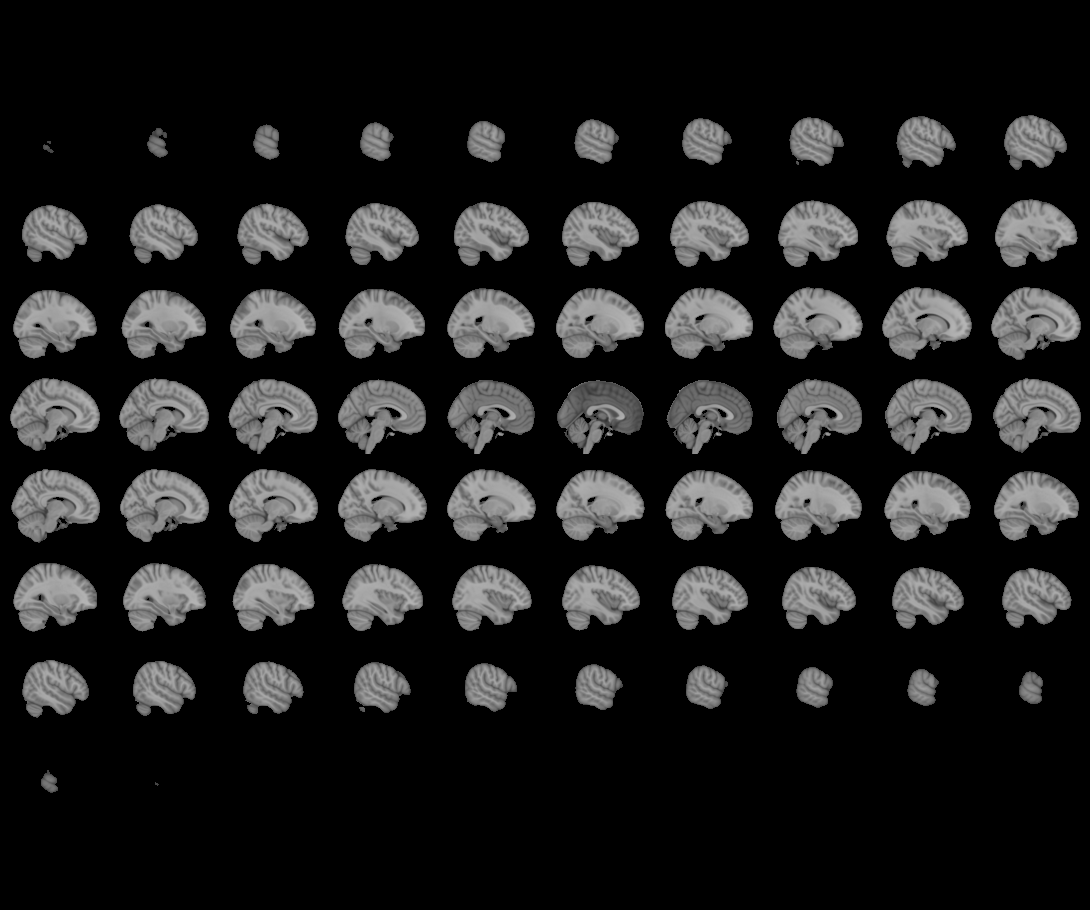
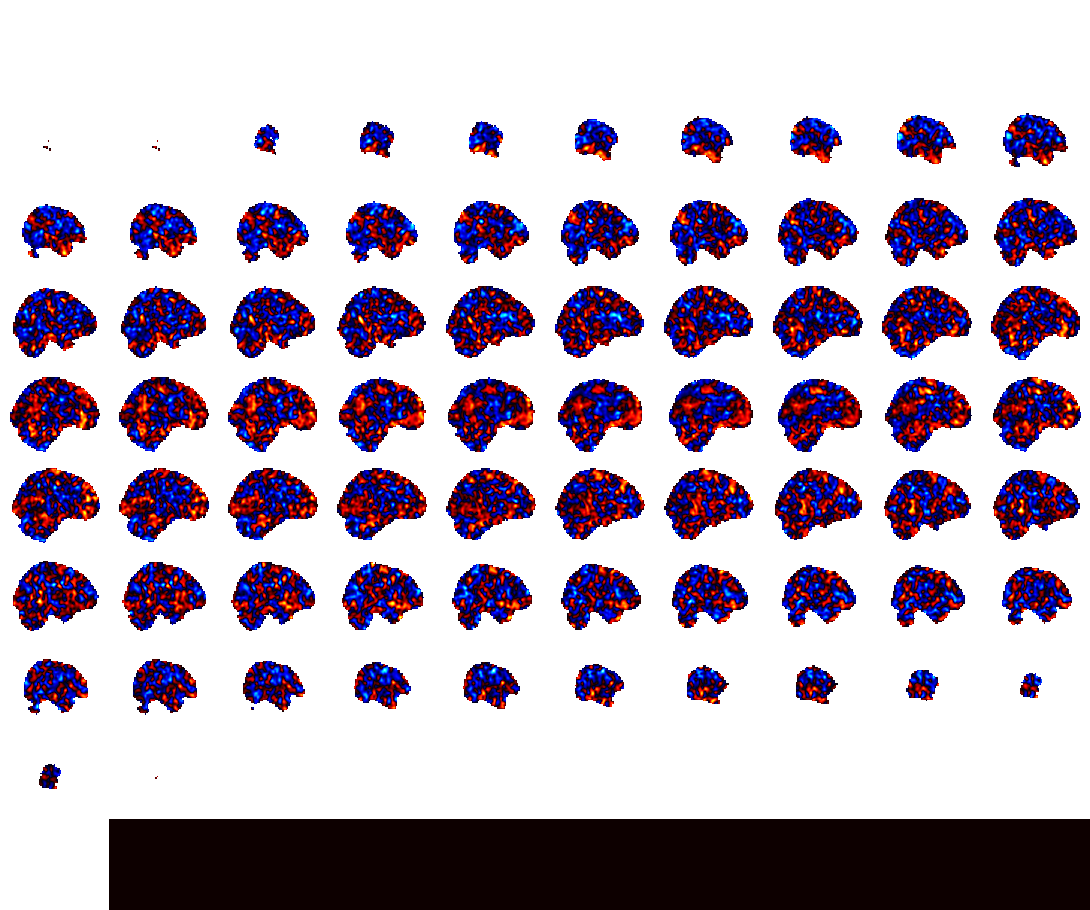

In [6]:
num_t = 50
img = model.masker_.inverse_transform(tseries[num_t,:])
plotting.view_img(img, cut_coords=[2, -22, 10], vmax=4)


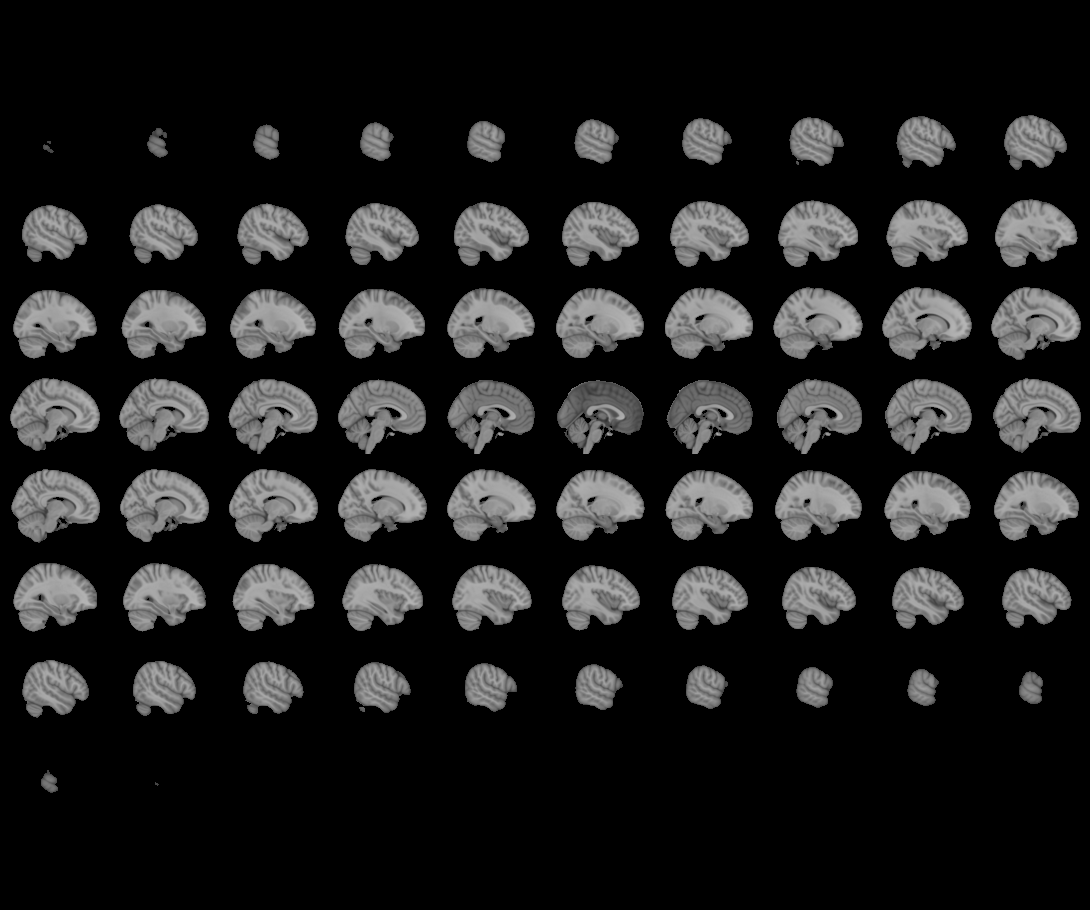
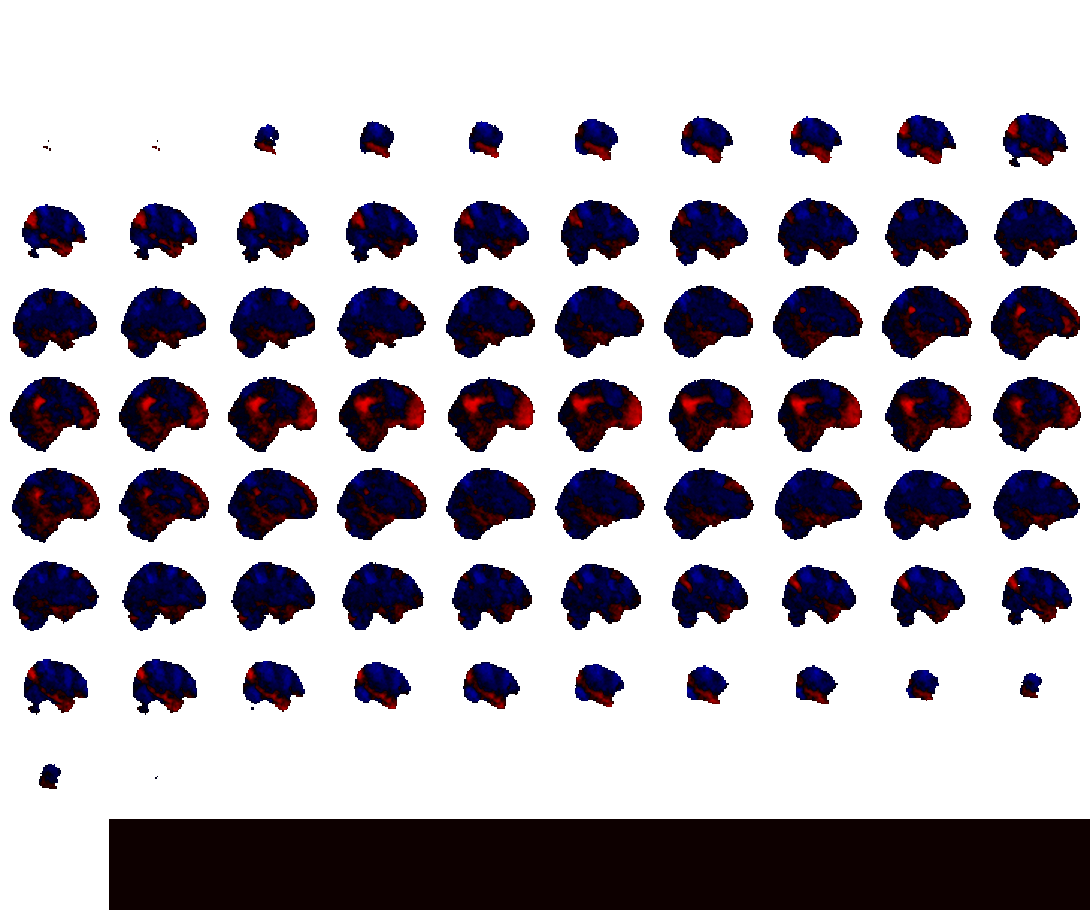

In [7]:
img_r = model.masker_.inverse_transform(tseries_r[num_t,:])
plotting.view_img(img_r, cut_coords=[2, -22, 10], vmax=4)


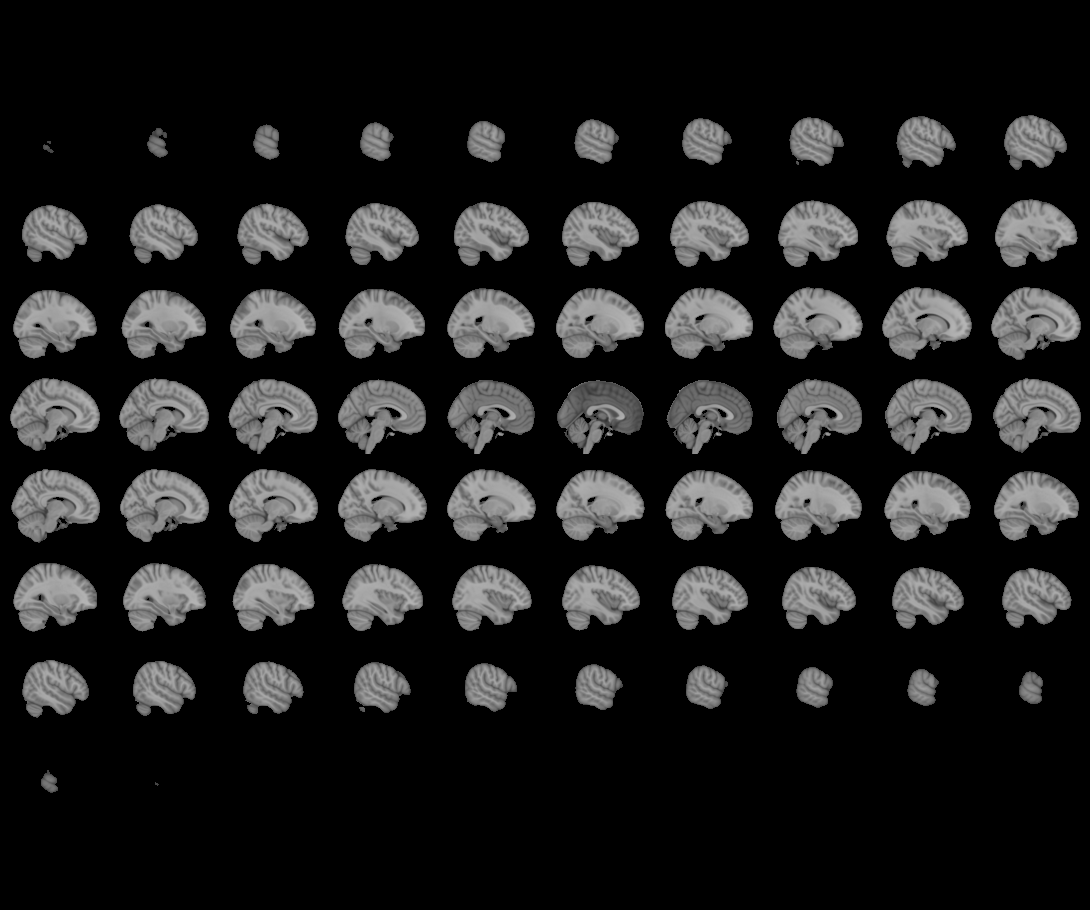
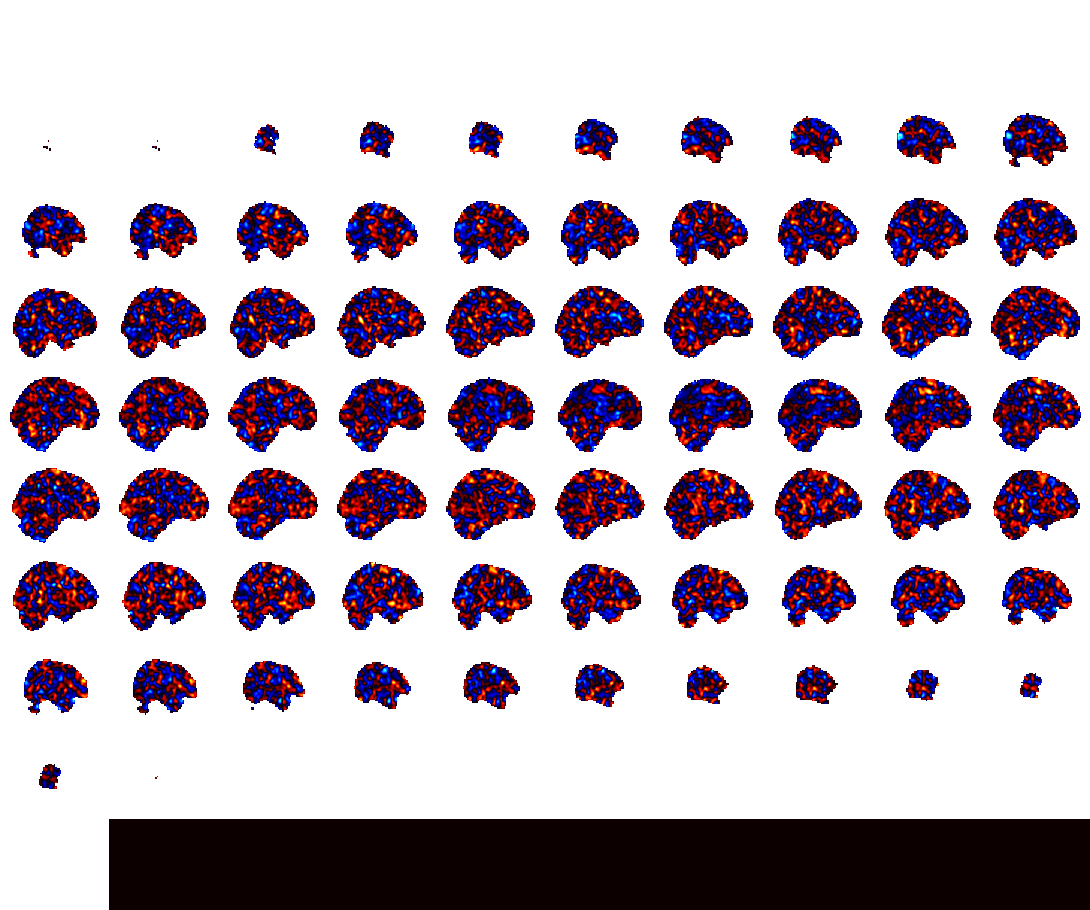

In [8]:
img_diff = image.new_img_like(img, img.get_fdata() - np.squeeze(img_r.get_fdata()))
plotting.view_img(img_diff, cut_coords=[2, -22, 10], vmax=4)

Let's calculate a std image of the residuals:


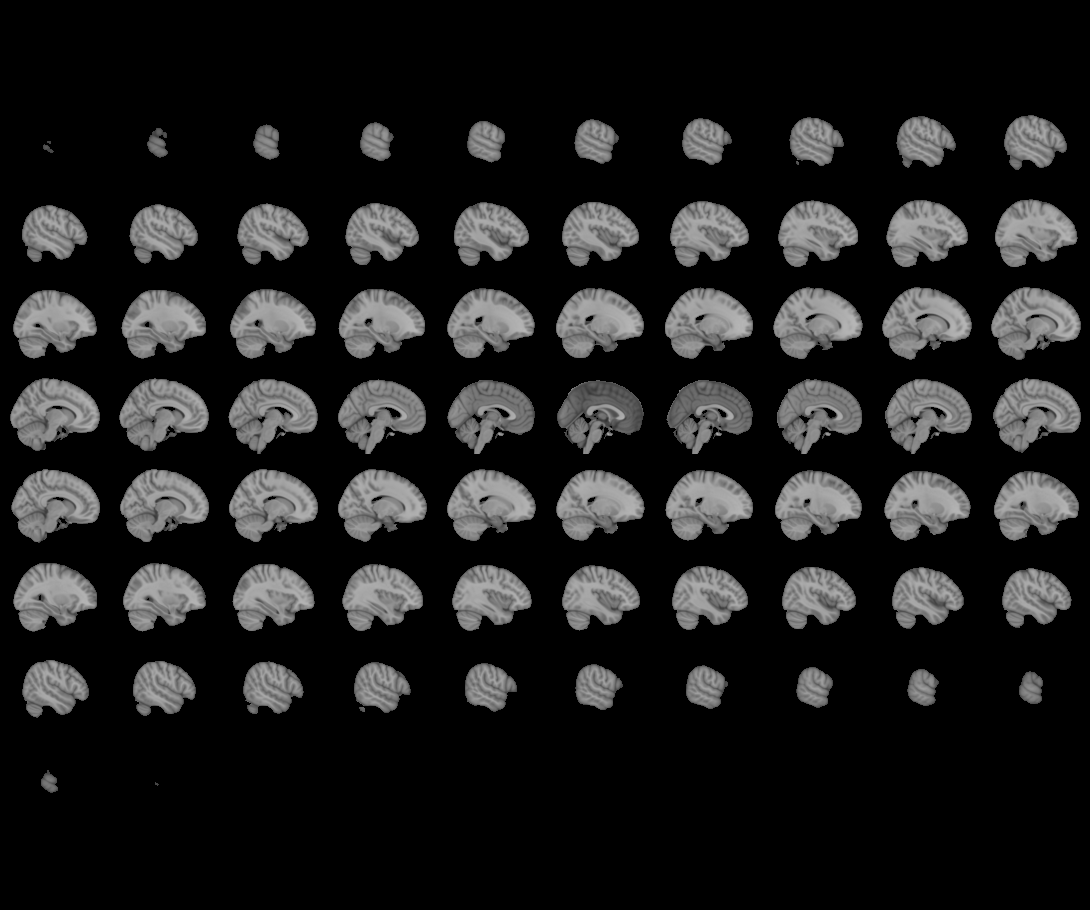
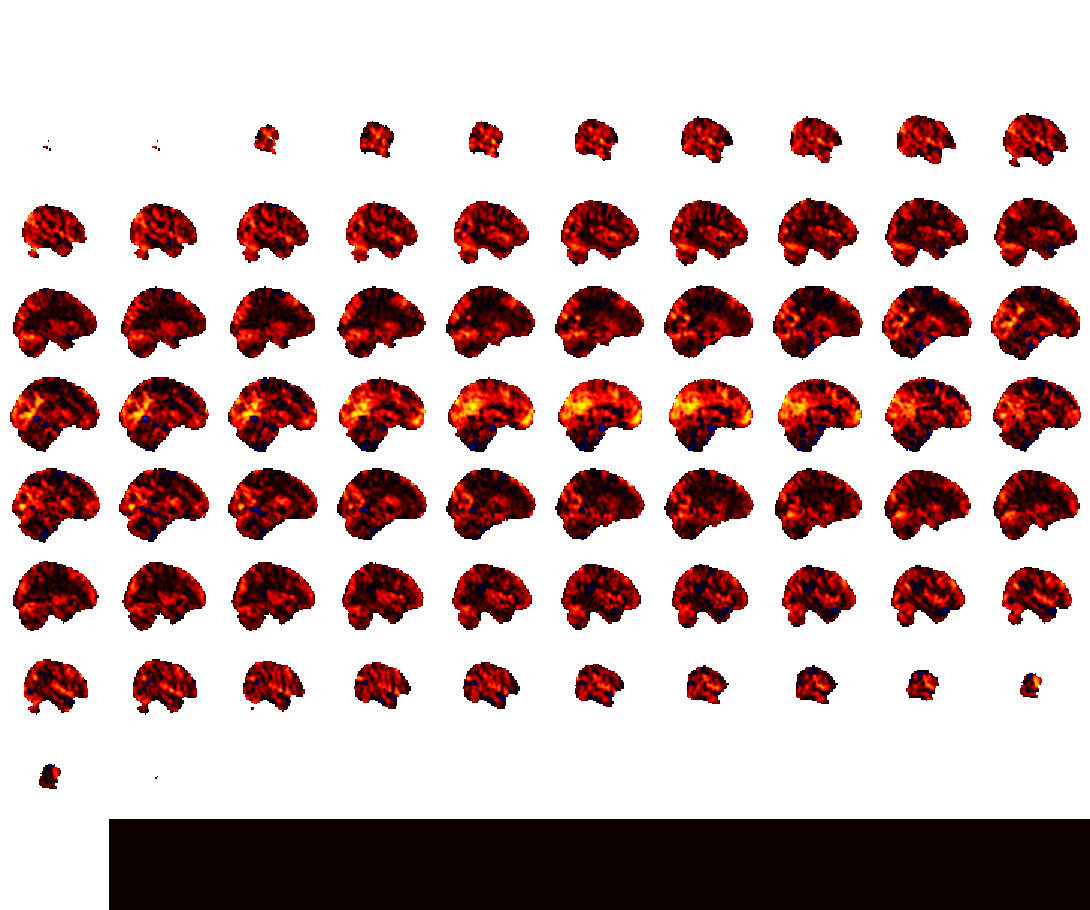

In [10]:
img_score = model.masker_.inverse_transform(emb.score(tseries))
plotting.view_img(img_score, cut_coords=[2, -22, 10], vmax=1)           

In [ ]:
tmp = emb.score(tseries)

In [ ]:
tmp